<a href="https://colab.research.google.com/github/wczubal1/BloombergTask/blob/main/BloombergTaskWitoldCzubala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from statistics import NormalDist

In [3]:
#!pip install scikit-learn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.9 MB/s eta 0:00:00


In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
from numpy import linalg

In [39]:
from scipy.stats import multivariate_normal
from statistics import NormalDist

In [54]:
from scipy.stats import norm

In [5]:
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import shap

In [6]:
#Uploading corporate PD datset
data_root = "https://raw.githubusercontent.com/wczubal1/BloombergTask/main/"
df_credit = pd.read_csv(data_root + "df_credit.csv")

In [7]:
df_credit

,Instrument,CompanyName,BusinessSector,CompanyMarketCap,CreditCombinedPD,ReturnOnAssets,TotalDebttoCommonEquity,PriceMomentumT12MVolatility
0,TXG.OQ,10X Genomics Inc,Healthcare Services & Equipment,5.554622e+09,0.083735,-16.21,NaN,14.111801
1,FCNCA.OQ,First Citizens BancShares Inc (Delaware),Banking & Investment Services,2.005774e+10,0.251288,1.01,0.92905,24.651832
2,ME.OQ,23andMe Holding Co.,Healthcare Services & Equipment,3.392539e+08,0.235883,-29.76,NaN,14.719923
3,TSVT.OQ,2Seventy Bio Inc,Pharmaceuticals & Medical Research,1.893360e+08,0.414782,NaN,NaN,34.163690
4,DDD.N,3D Systems Corp,Technology Equipment,6.925227e+08,0.459605,-1.96,0.60469,21.900110
...,...,...,...,...,...,...,...,...
2324,ZI.OQ,Zoominfo Technologies Inc,Software & IT Services,6.127379e+09,0.216172,5.20,0.54393,18.089863
2325,ZS.OQ,Zscaler Inc,Software & IT Services,3.423091e+10,0.049608,8.65,1.56412,16.097909
2326,ZUMZ.OQ,Zumiez Inc,Retailers,3.589960e+08,0.233710,2.61,0.00000,13.146578
2327,ZUO.N,Zuora Inc,Software & IT Services,1.209195e+09,0.081718,NaN,2.16553,16.002749


In [8]:
#Count of rows with missing values
print (df_credit.isna().any(axis=1).sum())

802


In [64]:
#Removing missing values and resetting index
df_credit=df_credit.dropna()
df_credit= df_credit.reset_index(drop=True)

In [10]:
df_credit['CreditCombinedPD'].describe()
#df_credit['randNumCol'].describe()

count    1527.000000
mean        0.283032
std         0.493445
min         0.006694
25%         0.074972
50%         0.140495
75%         0.269909
max         5.972882
Name: CreditCombinedPD, dtype: float64

In [11]:
np.random.seed(12345);
df_credit.loc[:,'randNumCol'] = np.random.uniform(0, 1, df_credit.shape[0])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
#simulating default
#scaling parameter
k=5
df_credit.loc[:,'Default'] = df_credit['randNumCol']<(k*df_credit['CreditCombinedPD']/100)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
print('Number of defaults: ', sum(df_credit['Default']))
#df_credit.loc[df_credit['Default']==True]
df_credit.loc[df_credit['Default']==True,['Default','BusinessSector']].groupby('BusinessSector').sum()

Number of defaults:  27


,Default
BusinessSector,
Applied Resources,1
Banking & Investment Services,4
Cyclical Consumer Products,2
Cyclical Consumer Services,2
Food & Beverages,2
Healthcare Services & Equipment,1
Industrial Goods,2
Real Estate,4
Renewable Energy,1


In [14]:
#Sector variables
df_credit.groupby('BusinessSector').size()

BusinessSector
Applied Resources                                   17
Automobiles & Auto Parts                            23
Banking & Investment Services                      199
Chemicals                                           32
Consumer Goods Conglomerates                         6
Cyclical Consumer Products                          64
Cyclical Consumer Services                          78
Energy - Fossil Fuels                               67
Financial Technology (Fintech) & Infrastructure      8
Food & Beverages                                    44
Food & Drug Retailing                               12
Healthcare Services & Equipment                    109
Industrial & Commercial Services                    68
Industrial Goods                                   100
Insurance                                           40
Mineral Resources                                   19
Personal & Household Products & Services            19
Pharmaceuticals & Medical Research                

In [15]:
#Creating dummies for selected sector
dummies=pd.get_dummies(df_credit['BusinessSector'])
#keeping these sectors: Finance due to contagion, Real Estate rates sensitivity and Healthcare and Utilities not sensitive to economic cycle
dummies=dummies[['Banking & Investment Services','Healthcare Services & Equipment','Real Estate','Utilities']]
df_credit=pd.concat([df_credit, dummies],axis=1)

In [16]:
#Estimation dataset (dropping several columns)
df_estimation= df_credit[df_credit.columns.difference(['Instrument', 'CompanyName', 'BusinessSector', 'CompanyMarketCap', 'CreditCombinedPD', 'randNumCol'])]

In [17]:
df_estimation.columns

Index(['Banking & Investment Services', 'Default',
       'Healthcare Services & Equipment', 'PriceMomentumT12MVolatility',
       'Real Estate', 'ReturnOnAssets', 'TotalDebttoCommonEquity',
       'Utilities'],
      dtype='object')

In [18]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_estimation.drop(['Default'],axis=1), df_estimation['Default'], test_size=0.25)

# Create the logistic regression model
#model = LogisticRegression()
#Adding regularization penalty and inverse of regularization strength
model = LogisticRegression(penalty='l1', C=12, solver='liblinear',max_iter=1000,class_weight={0: 0.08, 1: 0.92})

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

In [19]:
# Evaluate the model
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)
accuracy = model.score(X_train, y_train)
print('Accuracy:', accuracy)

Accuracy: 0.9764397905759162
Accuracy: 0.9755458515283842


In [20]:
model.coef_
#df_estimation.drop(['Default'],axis=1).columns,
pd.DataFrame([df_estimation.drop(['Default'],axis=1).columns,np.transpose(model.coef_)]).T.sort_values(1)

,0,1
1,Healthcare Services & Equipment,[-0.20609965367075372]
5,TotalDebttoCommonEquity,[-0.007484619195448311]
4,ReturnOnAssets,[0.001598403621164644]
2,PriceMomentumT12MVolatility,[0.060745969438535746]
0,Banking & Investment Services,[0.13086849706915402]
6,Utilities,[0.9641240761933115]
3,Real Estate,[1.2399353172459]


In [21]:
confusion_matrix(y_test, model.predict(X_test))
#confusion_matrix(y_train, model.predict(X_train))

array([[373,   3],
       [  6,   0]])

In [22]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      1124
        True       0.11      0.05      0.07        21

    accuracy                           0.98      1145
   macro avg       0.55      0.52      0.53      1145
weighted avg       0.97      0.98      0.97      1145



In [23]:
final_model = XGBClassifier(objective = "binary:logistic",
                         n_estimators = 99,
                         gamma = 0,
                         importance_type='gain',
                         eval_metric = "mlogloss",
                         max_depth = 3,
                         learning_rate = 0.05,
                         max_delta_step=0,
                         booster="gbtree",
                         min_child_weight = 1,
                         scale_pos_weight = None,
                         verbosity = 1)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=99,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

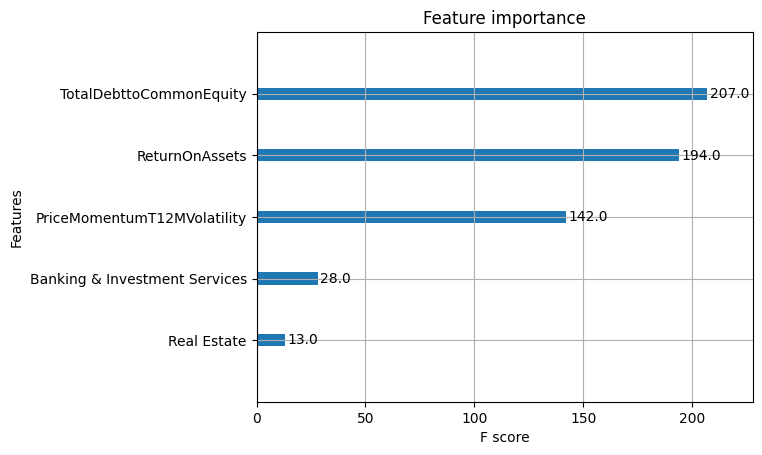

In [24]:
from xgboost import plot_importance
import matplotlib.pylab as plt
from matplotlib import pyplot
plot_importance(final_model, max_num_features=10)
plt.show()
plt.close()

In [25]:
confusion_matrix(y_test, final_model.predict(X_test))
#confusion_matrix(y_train, final_model.predict(X_train))

array([[376,   0],
       [  6,   0]])

In [26]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       376
        True       0.00      0.00      0.00         6

    accuracy                           0.98       382
   macro avg       0.49      0.50      0.49       382
weighted avg       0.97      0.98      0.97       382



In [27]:
# loading
explainer = shap.TreeExplainer(final_model, data=X_train, model_output="probability")
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

[23:36:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


(1145, 7)


In [28]:
#for i in range(0,X_train.shape[0]-1):
#    shap.dependence_plot(X_train.columns[i], shap_values, X_train, interaction_index=None, show=False)
#    plt.xlim(X_train[X_train.columns[i]].quantile(0.01),X_train[X_train.columns[i]].quantile(0.99))
#    plt.show()

In [75]:
#Create correlation matrix
corr_matrix=np.identity(df_credit.shape[0])
corr_matrix.shape[1]
df_credit.iloc[9,df_credit.columns.get_loc('BusinessSector')]

'Industrial & Commercial Services'

In [76]:
#value when business sector is Banking
BankingRows=df_credit[df_credit['BusinessSector']=='Banking & Investment Services'].index

for r in BankingRows:
    for c in BankingRows:
        corr_matrix[r, c]=0.95


In [66]:
df_credit[df_credit['BusinessSector']=='Banking & Investment Services'].index

Int64Index([   0,    5,   33,   67,   85,   90,   91,  126,  132,  140,
            ...
            1472, 1474, 1478, 1480, 1482, 1496, 1501, 1503, 1509, 1521],
           dtype='int64', length=199)

In [69]:
#checking if Banking have correct correlations
with np.printoptions(threshold=np.inf):
    print(corr_matrix[:,0])

[1.  0.  0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.
 0.7 0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.7 0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.7 0.7 0.  0.
 0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.7 0.7 0.7 0.  0.7
 0.7 0.7 0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.7 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.7 0.7 0.7
 0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.7 0.  0.  0.  0.  0.  0.  0.  0.  0.7 0.  0.  0

In [77]:
#Adding 1s to diagonal
np.fill_diagonal(corr_matrix, 1)

In [78]:
L=linalg.cholesky(corr_matrix)

In [110]:
Lambda=np.matmul(np.identity(df_credit.shape[0]),L.T)
# Create a multivariate normal distribution object
mvn = np.random.multivariate_normal(np.zeros((df_credit.shape[0])),Lambda,size=500)

covariance is not positive-semidefinite.


In [111]:
norm.cdf(mvn)
df_corr=pd.DataFrame(norm.cdf(mvn).T)
df_corr

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.334096,0.250919,0.749455,0.644693,0.611450,0.604197,0.499167,0.132854,0.302642,0.288873,...,0.261057,0.626346,0.550371,0.759704,0.701636,0.424633,0.374017,0.495737,0.761047,0.314565
1,0.011316,0.312225,0.096826,0.194637,0.566326,0.604183,0.517258,0.187562,0.916885,0.388686,...,0.464549,0.017008,0.875838,0.084984,0.856763,0.377343,0.033298,0.462532,0.723487,0.916350
2,0.669097,0.070833,0.403660,0.439494,0.670003,0.867399,0.294658,0.084242,0.449157,0.468506,...,0.184897,0.949919,0.659274,0.937815,0.937767,0.414274,0.002738,0.914469,0.304954,0.943128
3,0.127091,0.419467,0.701975,0.266941,0.619369,0.189403,0.246419,0.883197,0.022161,0.633812,...,0.495634,0.812105,0.045152,0.356548,0.730462,0.713063,0.435505,0.820159,0.292052,0.375281
4,0.255799,0.441460,0.501152,0.897975,0.717760,0.454518,0.324397,0.539536,0.981010,0.350585,...,0.471477,0.388785,0.436773,0.803209,0.848810,0.352722,0.682707,0.508348,0.642486,0.487781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,0.113861,0.971422,0.340625,0.623513,0.848845,0.824247,0.720093,0.861426,0.036911,0.535513,...,0.653325,0.916253,0.116793,0.421419,0.066532,0.871695,0.142331,0.789316,0.944807,0.104829
1523,0.711651,0.480086,0.523109,0.985469,0.326986,0.838734,0.807168,0.760462,0.888987,0.081413,...,0.616306,0.245856,0.333562,0.615763,0.931391,0.391075,0.786707,0.959344,0.597863,0.840644
1524,0.342920,0.689625,0.794881,0.347570,0.205489,0.586320,0.304930,0.204456,0.540036,0.469588,...,0.114162,0.916208,0.680436,0.323375,0.082481,0.181489,0.881099,0.949067,0.592596,0.704268
1525,0.222356,0.298717,0.083802,0.217699,0.678609,0.892977,0.221595,0.615123,0.578240,0.127555,...,0.499077,0.552305,0.483146,0.928021,0.590897,0.961101,0.083575,0.198954,0.047125,0.647757


In [112]:
df_corr =df_corr < k*df_credit[['CreditCombinedPD']].values/100

In [113]:
df_corr.loc[:,'BusinessSector'] = df_credit['BusinessSector']

In [114]:
df_corr.groupby('BusinessSector').sum().max(axis=1)

BusinessSector
Applied Resources                                  3
Automobiles & Auto Parts                           2
Banking & Investment Services                      1
Chemicals                                          3
Consumer Goods Conglomerates                       1
Cyclical Consumer Products                         4
Cyclical Consumer Services                         5
Energy - Fossil Fuels                              6
Financial Technology (Fintech) & Infrastructure    2
Food & Beverages                                   2
Food & Drug Retailing                              2
Healthcare Services & Equipment                    5
Industrial & Commercial Services                   3
Industrial Goods                                   5
Insurance                                          3
Mineral Resources                                  3
Personal & Household Products & Services           3
Pharmaceuticals & Medical Research                 4
Real Estate                    

In [81]:
#df_credit.loc[:,'randNumColCorr'] = norm.cdf(mvn)
#df_credit.loc[:,'DefaultCorr'] = df_credit['randNumColCorr']<(k*df_credit['CreditCombinedPD']/100)

In [82]:
print('Number of defaults (where Banking Defaults are Correlated): ', sum(df_credit['DefaultCorr']))
#df_credit.loc[df_credit['Default']==True]
#df_credit.loc[df_credit['DefaultCorr']==True,['DefaultCorr','BusinessSector']].groupby('BusinessSector').sum()

Number of defaults (where Banking Defaults are Correlated):  17


,DefaultCorr
BusinessSector,
Cyclical Consumer Services,2
Healthcare Services & Equipment,3
Industrial Goods,1
Personal & Household Products & Services,1
Real Estate,5
Retailers,1
Software & IT Services,1
Technology Equipment,2
Utilities,1
